# Imports,  Settings and Paths

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time

In [2]:
from Code.Models.c7o2h10_model import DeepPotential, train, normalize, backtransform

In [3]:
data_path = './Dataset/c7o2h10_X.npy'
label_path = './Dataset/c7o2h10_Y.npy'
model_path = './ModelCheckpoints/c7o2h10/'

In [4]:
use_cuda = torch.cuda.is_available()
print('use cuda:  ', use_cuda)

use cude:   False


# Read the Data

In [5]:
X_train_npy = np.load(data_path)
Y_train_npy = np.load(label_path) * -1
X_train_npy.shape

(404000, 19, 72)

### Check for NaN values

In [6]:
use_ids = np.where(np.isnan(X_train_npy).sum(axis=2).sum(axis=1)==0)
print('{} Datapoints with NaN values found.'.format(X_train_npy.shape[0] - len(use_ids[0])))

0 Datapoints with NaN values found.


In [7]:
X_train_npy = X_train_npy[use_ids]
Y_train_npy = Y_train_npy[use_ids]
X_train_npy.shape

(404000, 19, 72)

### Shuffle the Dataset

In [8]:
shuffle = np.arange(X_train_npy.shape[0])
np.random.shuffle(shuffle)
X_train_npy = X_train_npy[shuffle]
Y_train_npy = Y_train_npy[shuffle]

### Create Pytorch Variables

In [9]:
if use_cuda:
    X_data = Variable(torch.Tensor(X_train_npy).cuda())
    Y_data = Variable(torch.Tensor(Y_train_npy).cuda(), requires_grad=False)
else:
    X_data = Variable(torch.Tensor(X_train_npy))
    Y_data = Variable(torch.Tensor(Y_train_npy), requires_grad=False)

# Train Model

## Do the learning


Epoch: 0	learning rate: 0.01
---
total: 0.1 %	current epoch: 4.0 %	loss: 0.070068	time estimate: 256.1 min
total: 0.3 %	current epoch: 7.9 %	loss: 0.005921	time estimate: 258.7 min
total: 0.4 %	current epoch: 11.9 %	loss: 0.00456	time estimate: 260.0 min
total: 0.5 %	current epoch: 15.8 %	loss: 0.004025	time estimate: 260.9 min
total: 0.7 %	current epoch: 19.8 %	loss: 0.003645	time estimate: 259.1 min
total: 0.8 %	current epoch: 23.8 %	loss: 0.003302	time estimate: 256.9 min
total: 0.9 %	current epoch: 27.7 %	loss: 0.003118	time estimate: 255.2 min
total: 1.1 %	current epoch: 31.7 %	loss: 0.002927	time estimate: 255.4 min
total: 1.2 %	current epoch: 35.7 %	loss: 0.002845	time estimate: 255.5 min
total: 1.3 %	current epoch: 39.6 %	loss: 0.002659	time estimate: 255.4 min
total: 1.5 %	current epoch: 43.6 %	loss: 0.002672	time estimate: 255.5 min
total: 1.6 %	current epoch: 47.5 %	loss: 0.002577	time estimate: 253.1 min
total: 1.7 %	current epoch: 51.5 %	loss: 0.002541	time estimate: 253.

total: 14.0 %	current epoch: 19.8 %	loss: 0.001621	time estimate: 222.6 min
total: 14.1 %	current epoch: 23.8 %	loss: 0.001564	time estimate: 222.4 min
total: 14.3 %	current epoch: 27.7 %	loss: 0.001585	time estimate: 222.1 min
total: 14.4 %	current epoch: 31.7 %	loss: 0.001521	time estimate: 221.7 min
total: 14.5 %	current epoch: 35.7 %	loss: 0.001609	time estimate: 221.5 min
total: 14.7 %	current epoch: 39.6 %	loss: 0.00155	time estimate: 221.2 min
total: 14.8 %	current epoch: 43.6 %	loss: 0.001568	time estimate: 220.9 min
total: 14.9 %	current epoch: 47.5 %	loss: 0.001539	time estimate: 220.6 min
total: 15.1 %	current epoch: 51.5 %	loss: 0.001558	time estimate: 220.3 min
total: 15.2 %	current epoch: 55.5 %	loss: 0.001522	time estimate: 219.9 min
total: 15.3 %	current epoch: 59.4 %	loss: 0.001522	time estimate: 219.6 min
total: 15.4 %	current epoch: 63.4 %	loss: 0.001496	time estimate: 219.3 min
total: 15.6 %	current epoch: 67.4 %	loss: 0.001528	time estimate: 219.0 min
total: 15.7 %

total: 27.9 %	current epoch: 35.7 %	loss: 0.001314	time estimate: 186.8 min
total: 28.0 %	current epoch: 39.6 %	loss: 0.00129	time estimate: 186.5 min
total: 28.1 %	current epoch: 43.6 %	loss: 0.001277	time estimate: 186.1 min
total: 28.3 %	current epoch: 47.5 %	loss: 0.001291	time estimate: 185.7 min
total: 28.4 %	current epoch: 51.5 %	loss: 0.001297	time estimate: 185.3 min
total: 28.5 %	current epoch: 55.5 %	loss: 0.001265	time estimate: 185.0 min
total: 28.6 %	current epoch: 59.4 %	loss: 0.001254	time estimate: 184.7 min
total: 28.8 %	current epoch: 63.4 %	loss: 0.001253	time estimate: 184.3 min
total: 28.9 %	current epoch: 67.4 %	loss: 0.001258	time estimate: 184.0 min
total: 29.0 %	current epoch: 71.3 %	loss: 0.00132	time estimate: 183.7 min
total: 29.2 %	current epoch: 75.3 %	loss: 0.001267	time estimate: 183.3 min
total: 29.3 %	current epoch: 79.2 %	loss: 0.001276	time estimate: 183.0 min
total: 29.4 %	current epoch: 83.2 %	loss: 0.001279	time estimate: 182.7 min
total: 29.6 %	

total: 41.7 %	current epoch: 51.5 %	loss: 0.001075	time estimate: 151.7 min
total: 41.8 %	current epoch: 55.5 %	loss: 0.001035	time estimate: 151.3 min
total: 42.0 %	current epoch: 59.4 %	loss: 0.001054	time estimate: 150.9 min
total: 42.1 %	current epoch: 63.4 %	loss: 0.001047	time estimate: 150.6 min
total: 42.2 %	current epoch: 67.4 %	loss: 0.001063	time estimate: 150.3 min
total: 42.4 %	current epoch: 71.3 %	loss: 0.001086	time estimate: 149.9 min
total: 42.5 %	current epoch: 75.3 %	loss: 0.001046	time estimate: 149.6 min
total: 42.6 %	current epoch: 79.2 %	loss: 0.001047	time estimate: 149.3 min
total: 42.8 %	current epoch: 83.2 %	loss: 0.001078	time estimate: 149.0 min
total: 42.9 %	current epoch: 87.2 %	loss: 0.001061	time estimate: 148.7 min
total: 43.0 %	current epoch: 91.1 %	loss: 0.001028	time estimate: 148.3 min
total: 43.2 %	current epoch: 95.1 %	loss: 0.001046	time estimate: 148.0 min
total: 43.3 %	current epoch: 99.0 %	loss: 0.001039	time estimate: 147.6 min
saved checkp

total: 55.4 %	current epoch: 63.4 %	loss: 0.000889	time estimate: 116.3 min
total: 55.6 %	current epoch: 67.4 %	loss: 0.000894	time estimate: 116.0 min
total: 55.7 %	current epoch: 71.3 %	loss: 0.000925	time estimate: 115.6 min
total: 55.8 %	current epoch: 75.3 %	loss: 0.000889	time estimate: 115.3 min
total: 56.0 %	current epoch: 79.2 %	loss: 0.000899	time estimate: 114.9 min
total: 56.1 %	current epoch: 83.2 %	loss: 0.000927	time estimate: 114.6 min
total: 56.2 %	current epoch: 87.2 %	loss: 0.000899	time estimate: 114.2 min
total: 56.4 %	current epoch: 91.1 %	loss: 0.000877	time estimate: 113.9 min
total: 56.5 %	current epoch: 95.1 %	loss: 0.000895	time estimate: 113.5 min
total: 56.6 %	current epoch: 99.0 %	loss: 0.00089	time estimate: 113.2 min
saved checkpoint at: ./ModelCheckpoints/c7o2h10/epoch_16


Epoch: 17	learning rate: 0.0063
---
total: 56.8 %	current epoch: 4.0 %	loss: 0.000905	time estimate: 112.8 min
total: 56.9 %	current epoch: 7.9 %	loss: 0.000875	time estimate: 112.4 

total: 69.3 %	current epoch: 79.2 %	loss: 0.000772	time estimate: 80.2 min
total: 69.4 %	current epoch: 83.2 %	loss: 0.000803	time estimate: 79.8 min
total: 69.6 %	current epoch: 87.2 %	loss: 0.000771	time estimate: 79.5 min
total: 69.7 %	current epoch: 91.1 %	loss: 0.000759	time estimate: 79.1 min
total: 69.8 %	current epoch: 95.1 %	loss: 0.000775	time estimate: 78.8 min
total: 70.0 %	current epoch: 99.0 %	loss: 0.00076	time estimate: 78.4 min
saved checkpoint at: ./ModelCheckpoints/c7o2h10/epoch_20


Epoch: 21	learning rate: 0.00565
---
total: 70.1 %	current epoch: 4.0 %	loss: 0.000782	time estimate: 78.0 min
total: 70.3 %	current epoch: 7.9 %	loss: 0.000761	time estimate: 77.7 min
total: 70.4 %	current epoch: 11.9 %	loss: 0.000751	time estimate: 77.3 min
total: 70.5 %	current epoch: 15.8 %	loss: 0.00077	time estimate: 77.0 min
total: 70.7 %	current epoch: 19.8 %	loss: 0.00077	time estimate: 76.6 min
total: 70.8 %	current epoch: 23.8 %	loss: 0.000756	time estimate: 76.3 min
total: 70

total: 83.3 %	current epoch: 99.0 %	loss: 0.000675	time estimate: 43.8 min
saved checkpoint at: ./ModelCheckpoints/c7o2h10/epoch_24


Epoch: 25	learning rate: 0.00506
---
total: 83.5 %	current epoch: 4.0 %	loss: 0.000694	time estimate: 43.3 min
total: 83.6 %	current epoch: 7.9 %	loss: 0.000666	time estimate: 43.0 min
total: 83.7 %	current epoch: 11.9 %	loss: 0.000667	time estimate: 42.6 min
total: 83.9 %	current epoch: 15.8 %	loss: 0.000684	time estimate: 42.3 min
total: 84.0 %	current epoch: 19.8 %	loss: 0.000679	time estimate: 41.9 min
total: 84.1 %	current epoch: 23.8 %	loss: 0.000663	time estimate: 41.6 min
total: 84.3 %	current epoch: 27.7 %	loss: 0.000695	time estimate: 41.2 min
total: 84.4 %	current epoch: 31.7 %	loss: 0.000698	time estimate: 40.9 min
total: 84.5 %	current epoch: 35.7 %	loss: 0.000679	time estimate: 40.6 min
total: 84.7 %	current epoch: 39.6 %	loss: 0.000685	time estimate: 40.2 min
total: 84.8 %	current epoch: 43.6 %	loss: 0.000685	time estimate: 39.9 min
total:

total: 97.2 %	current epoch: 15.8 %	loss: 0.000599	time estimate: 7.4 min
total: 97.3 %	current epoch: 19.8 %	loss: 0.000612	time estimate: 7.0 min
total: 97.5 %	current epoch: 23.8 %	loss: 0.000595	time estimate: 6.7 min
total: 97.6 %	current epoch: 27.7 %	loss: 0.000632	time estimate: 6.3 min
total: 97.7 %	current epoch: 31.7 %	loss: 0.000642	time estimate: 6.0 min
total: 97.9 %	current epoch: 35.7 %	loss: 0.000625	time estimate: 5.6 min
total: 98.0 %	current epoch: 39.6 %	loss: 0.000621	time estimate: 5.3 min
total: 98.1 %	current epoch: 43.6 %	loss: 0.000624	time estimate: 4.9 min
total: 98.3 %	current epoch: 47.5 %	loss: 0.000602	time estimate: 4.6 min
total: 98.4 %	current epoch: 51.5 %	loss: 0.000598	time estimate: 4.2 min
total: 98.5 %	current epoch: 55.5 %	loss: 0.000585	time estimate: 3.9 min
total: 98.6 %	current epoch: 59.4 %	loss: 0.000583	time estimate: 3.6 min
total: 98.8 %	current epoch: 63.4 %	loss: 0.000596	time estimate: 3.2 min
total: 98.9 %	current epoch: 67.4 %	lo

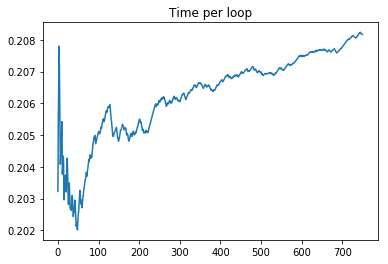

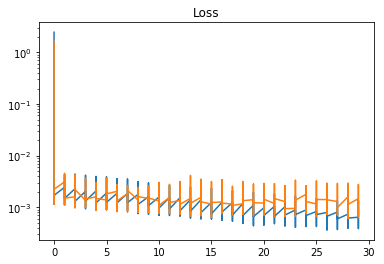

In [10]:
if use_cuda:
    init_deep_pot = DeepPotential().cuda()
else:
    init_deep_pot = DeepPotential()
init_optim = torch.optim.Adam(init_deep_pot.parameters())
deep_pot, optim = train(init_deep_pot, init_optim, X_data, Y_data,
                        30, 128, (0.01, 0.96, 1.5),
                        checkpoint_path=model_path, print_every=100)

In [11]:
test_size = 10000

In [15]:
#deep_pot = DeepPotential().cuda()
#deep_pot.load_state_dict(torch.load('./ModelCheckpoints/epoch_13'))
Y_result = deep_pot.forward(X_data[-test_size:])

In [16]:
result = backtransform(np.array(Y_result.data.tolist()).reshape(test_size), Y_data.min().item(), Y_data.max().item())

In [17]:
test = np.array(Y_data[-test_size:].data.tolist()).reshape(test_size)

In [18]:
np.mean(np.abs(test - result))

0.17701749558577795

## Test the model
### Mean Absolute Error
The desired accuracy is about 0.04 eV

In [19]:
mae = np.abs(deep_pot.forward(X_data[-500:]).data.numpy().reshape(500) - Y_data[-500:].data.numpy().reshape(500)).mean()
print('The nural network reaches a mean absolute error of {} eV'.format(mae))

The nural network reaches a mean absolute error of 11503.1220703125 eV


### Small test sample

In [ ]:
deep_pot.forward(X_data[-10:])

In [ ]:
Y_data[-10:]

## Save the Model Parameters

In [ ]:
torch.save(deep_pot.state_dict(), model_path)

## Continue learning

In [ ]:
deep_pot = DeepPotential()
deep_pot.load_state_dict(torch.load(model_path))
optim = torch.optim.Adam(deep_pot.parameters(), lr=1e-2)

In [ ]:
deep_pot, optim = train(deep_pot, optim, X_data, Y_data, 1000, 512, (0.001, 0.96, 1.5), use_for_train=0.9, print_every=10)